<a href="https://colab.research.google.com/github/FabioHerrera97/FlavorMiner/blob/main/FlavorMiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlavorMiner: Instructions to Run

This script contains the code necessary to run FlavorMiner. In oreder to run this code the user needs to organize the input data in an excel file containing either the PubChem ID or the isomeric smiles of the input compounds.

Name the column containing the isomeric smiles "Isomeric Smiles". This way there is no need to manipulate the code to run the analyzes.

IMPORTANT: This script requires scikit-learn version 1.2.2. The models trained to perform the respective predictions were trained and saved in joblib files with this version, and a different version with end up with and error at the moment to run the code. Use the code below to install it, if necessary

In [ ]:
!pip install -U scikit-learn==1.2.2

# 1. Upload the data

The first step to use FlavorMiner is to upload the excel file containing the data. To do this in Google Colab go to *Files> Upload>Select the file>Open*.

Then click the three dots on the right of the uploaded file and copy the path.

In [49]:
import pandas as pd

'''URL of the Excel file'''

file_url = 'https://github.com/FabioHerrera97/FlavorMiner/raw/main/Data/Cocoa%20metabolomics%20data.xlsx' # Copy here the path of the input file

''' Read the Excel file'''

data = pd.read_excel(file_url)

''' Print the contents of the DataFrame'''

data.head()

,Compound name,Fold Change,ID Level,PubChem ID,Isomeric Smiles,Processing stage
0,Tetrahydroxychal-\ncone 4’-O-(2’’-\nO-acetyl-6...,14.1,3,42607557,CC(=O)OC1[C@H]([C@@H](C(O[C@H]1OC2=C(C(=C(C=C2...,Fermentation
1,Tumonoic Acid H,12.2,3,25058105,CCCCCCCC[C@H](C)C(=O)N1CCC[C@H]1C(=O)O[C@H](C(...,Fermentation
2,Acetophenone,6.8,3,7410,CC(=O)C1=CC=CC=C1,Fermentation
3,Hydroxyacetophenone,6.1,3,7469,CC(=O)C1=CC=C(C=C1)O,Fermentation
4,Anhydrofructose,0.2,3,14299935,C1C(=O)C(C(C(O1)CO)O)O,Fermentation


# 2. Matching the input data with the flavor database.

IMPORTANT: This match is performed with the isomeric smiles, not the name of the compounds due to the lack of standardization in compounds name.

This part of the code takes the provided isomeric smiles and perform a database match to exclude from the prediction those entries with already reported flavor profiles. This avoids adding unnnecessary uncertainty when there is experimental data available.

In [50]:
''' Read the Excel file'''

database = pd.read_excel('https://github.com/FabioHerrera97/FlavorMiner/raw/main/Data/LabelDataBase.xlsx')

''' Print the contents of the DataFrame'''

database.head()

,Compound Name,pubChem ID,flavor profile,Isomeric Smiles,Source,Labels,Bitter,Floral,Fruity,Off_flavor,Nutty,Sour,Sweet,Unclassified
0,1-Aminopropan-2-ol,4,fishy,CC(CN)O,flavorDB,Off_flavor,0,0,0,1,0,0,0,0
1,2-Deoxyhexopyranose,40,sweet,C1C(C(C(OC1O)CO)O)O,flavorDB,Sweet,0,0,0,0,0,0,1,0
2,3-Methyl-2-oxovaleric acid,47,fruit,CCC(C)C(=O)C(=O)O,flavorDB,Fruity,0,0,1,0,0,0,0,0
3,3-Methyl-2-oxobutanoic acid,49,fruity,CC(C)C(=O)C(=O)O,flavorDB,Fruity,0,0,1,0,0,0,0,0
4,2-ketoglutaric acid,51,odorless,C(CC(=O)O)C(=O)C(=O)O,flavorDB,Unclassified,0,0,0,0,0,0,0,1


In [51]:
db_matches = data[data['Isomeric Smiles'].isin(database['Isomeric Smiles'])]
db_matches.head()

,Compound name,Fold Change,ID Level,PubChem ID,Isomeric Smiles,Processing stage
2,Acetophenone,6.8,3,7410,CC(=O)C1=CC=CC=C1,Fermentation
3,Hydroxyacetophenone,6.1,3,7469,CC(=O)C1=CC=C(C=C1)O,Fermentation
5,Gluconic acid,0.7,3,10690,C([C@H]([C@H]([C@@H]([C@H](C(=O)O)O)O)O)O)O,Fermentation
6,Raffinose,0.1,3,39242,C([C@@H]1[C@@H]([C@@H]([C@H]([C@H](O1)OC[C@@H]...,Fermentation
10,Methylcatechol,11.9,3,460,COC1=CC=CC=C1O,Fermentation


For this matches the flavor profile is assigned according the report in the database as well as a probability of 100% as their flavor profile is experimentally validated. Additionally, the source of the data recorded in the database is provided.

In [52]:
columns = ['Bitter', 'Floral', 'Fruity', 'Off_flavor', 'Nutty', 'Sour', 'Sweet', 'Source']

result_dict = {col: [] for col in columns}

for smiles in db_matches['Isomeric Smiles']:
    for col in columns:
        values = database[database['Isomeric Smiles'] == smiles][col].values
        result_dict[col].append(values[0])

for col in columns:
    db_matches = db_matches.copy()
    db_matches[col] = result_dict[col]

db_matches.head()

,Compound name,Fold Change,ID Level,PubChem ID,Isomeric Smiles,Processing stage,Bitter,Floral,Fruity,Off_flavor,Nutty,Sour,Sweet,Source
2,Acetophenone,6.8,3,7410,CC(=O)C1=CC=CC=C1,Fermentation,1,1,1,1,1,0,1,flavorDB
3,Hydroxyacetophenone,6.1,3,7469,CC(=O)C1=CC=C(C=C1)O,Fermentation,1,1,1,0,0,0,1,flavorDB
5,Gluconic acid,0.7,3,10690,C([C@H]([C@H]([C@@H]([C@H](C(=O)O)O)O)O)O)O,Fermentation,0,0,0,0,0,0,1,flavorDB
6,Raffinose,0.1,3,39242,C([C@@H]1[C@@H]([C@@H]([C@H]([C@H](O1)OC[C@@H]...,Fermentation,0,0,0,0,0,0,1,flavorDB
10,Methylcatechol,11.9,3,460,COC1=CC=CC=C1O,Fermentation,0,1,0,1,1,0,1,flavorDB


This data can be stored in an excel file. Run the following cell if you want to store it.

In [53]:
db_matches.to_excel('Database matches.xlsx', index=False)

# 3. Obtaining the data without reported flavor profile

The next step is obtaining the set of compounds without database matches. The structure of this molecules will be used for the prediction.

In [54]:
non_matches = data[~data['Isomeric Smiles'].isin(database['Isomeric Smiles'])]
non_matches.head()

,Compound name,Fold Change,ID Level,PubChem ID,Isomeric Smiles,Processing stage
0,Tetrahydroxychal-\ncone 4’-O-(2’’-\nO-acetyl-6...,14.1,3,42607557,CC(=O)OC1[C@H]([C@@H](C(O[C@H]1OC2=C(C(=C(C=C2...,Fermentation
1,Tumonoic Acid H,12.2,3,25058105,CCCCCCCC[C@H](C)C(=O)N1CCC[C@H]1C(=O)O[C@H](C(...,Fermentation
4,Anhydrofructose,0.2,3,14299935,C1C(=O)C(C(C(O1)CO)O)O,Fermentation
7,Sorbosone,0.5,3,24755546,C([C@H]([C@@H]([C@H](C(=O)C=O)O)O)O)O,Fermentation
8,Maltotetraose,0.2,4,446495,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@@H]2[...,Fermentation


# 4. Featurizing the compounds

In order to run the prediction it is required to transform the molecular structure into the mathematical representation that the trained algorithms require: RDKit molecular descriptors and Extended Connectivity Fingerprint.

For this, RDKit python library needs to be installed, as it is not a default library in Google Colab.

In [55]:
!pip install rdkit-pypi

The first representation obtained are the 200 RDKit molecular descriptors. This descriptors are obtained using the isomeric smiles as input.

In [56]:
''' Import the RDKit libraries for molecular descriptor calculation'''

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import Chem

''' Create a fucntion that extract all the RDKit molecular descriptors'''

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]

    for mol in mols:
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

''' Call the fucntion that extract all the RDKit molecular descriptors'''

Mol_descriptors,desc_names = RDkit_descriptors(non_matches ['Isomeric Smiles'])

df_RDKit_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)

df_RDKit_descriptors.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.671459,-1.761259,12.671459,0.050808,0.098362,606.580,576.340,606.173726,230,0,...,0,0,0,0,0,0,0,0,0,0
1,13.036577,-1.319601,13.036577,0.053305,0.267956,483.646,438.286,483.319603,196,0,...,0,0,0,0,0,0,0,0,4,0
2,10.649343,-1.415833,10.649343,0.246574,0.402243,162.141,152.061,162.052823,64,0,...,0,0,0,0,0,0,0,0,0,0
3,10.402816,-1.981806,10.402816,0.168670,0.260576,178.140,168.060,178.047738,70,0,...,0,0,0,0,0,0,0,0,0,0
4,10.858559,-2.020271,10.858559,0.783569,0.102836,666.579,624.243,666.221858,264,0,...,0,0,0,0,0,0,0,0,0,0


Before training the respective algorithms, the descriptors were cleaned by colineality and variance. Therefore, not all the 200 molecular descriptors will be accepted as input by the respective algorithms.

It is necessary to filter the input descriptors. For this, the file containing the test data is used to filter the input columns.

In [58]:
RDKit_test = pd.read_excel('https://github.com/FabioHerrera97/FlavorMiner/raw/main/Data/RDKit_test.xlsx')

x_RDKit_data = RDKit_test.drop(['Bitter', 'Floral', 'Fruity', 'Off_flavor', 'Nutty', 'Sour', 'Sweet'], axis=1)

input_columns_names_RDKit = x_RDKit_data.columns.tolist()
input_columns_names_RDKit

input_RDKit = df_RDKit_descriptors[input_columns_names_RDKit]

The first representation obtained are the Extended Connectivity Fingerprint, with a radio of 2. This results in a binary vector with a lenth of 1024 bits.  

In [59]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import Chem
from rdkit.Chem import AllChem

''' Generate a molecule from each isomeric smiles'''

smiles_non_matches = non_matches ['Isomeric Smiles']
mols = [Chem.MolFromSmiles(i) for i in smiles_non_matches]

''' Configure the extended connectivity fingerprint'''

radius=2
nBits=1024

''' Calculate the ECFP for each molecule'''

ECFP2 = [AllChem.GetMorganFingerprintAsBitVect(mol,radius=radius, nBits=nBits) for mol in mols]

ecfp2_name = [f'Bit_{i}' for i in range(nBits)]
ecfp2_bits = [list(l) for l in ECFP2]
df_ecfp_2 = pd.DataFrame(ecfp2_bits, index = non_matches.index, columns = ecfp2_name)
df_ecfp_2.head()

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Before training the respective algorithms, the descriptors were cleaned by colineality and variance. Therefore, not all the 200 molecular descriptors will be accepted as input by the respective algorithms.

It is necessary to filter the input descriptors. For this, the file containing the test data is used to filter the input columns.

In [60]:
columns_ecfp = pd.read_excel('https://github.com/FabioHerrera97/FlavorMiner/raw/main/Data/ECFP_test.xlsx')

x_ECFP_data = columns_ecfp.drop(['Bitter', 'Floral', 'Fruity', 'Off_flavor', 'Nutty', 'Sour', 'Sweet'], axis=1)

input_bits = x_ECFP_data.columns.tolist()

input_ECFP = df_ecfp_2[input_bits]

input_ECFP.head()

,Bit_1,Bit_10,Bit_1004,Bit_1009,Bit_1010,Bit_1017,Bit_1019,Bit_102,Bit_1020,Bit_104,...,Bit_953,Bit_960,Bit_962,Bit_964,Bit_965,Bit_967,Bit_980,Bit_981,Bit_992,Bit_998
0,0,0,0,1,0,1,1,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# 5. Performing the prediction on those compounds with unknown flavor profiles.

The first step to perform the prediction is to import the models. These models are stored in a Zenodo repository ([https://zenodo.org/records/8435106](https://)). These model were stored in Zeno because they exceded the maximum size allowed by GitHub.

After importing the models, the prediction is run. Similarly, the probability is calculated as measure of the confidence of the prediction for each entry.

This process is first performed for the models trained with Extended Connectivity Fingerprint.

In [82]:
import joblib
import numpy as np

ecfp_model_urls = [
    'https://zenodo.org/records/8435106/files/Bitter_Random_Forest_SMOTE.sav?download=1',
    'https://zenodo.org/records/8435106/files/Sour_KNN_SMOTE.sav?download=1',
    'https://zenodo.org/records/8435106/files/Fruity_Random_Forest_SMOTE.sav?download=1',
    'https://zenodo.org/records/10033243/files/Sweet_updated_RF_Final.sav?download=1',
]

# Download the model files from Zenodo and load them
ecfp_models = []

for model_url in ecfp_model_urls:
    model_file_name = model_url.split('/')[-1]
    !wget -O {model_file_name} {model_url}
    model = joblib.load(model_file_name)
    ecfp_models.append(model)

predictions_ecfp = []
positive_probabilities_ecfp = []

for model in ecfp_models:
    probabilities = model.predict_proba(input_ECFP)
    positive_probabilities = probabilities[:, 0]
    predictions = model.predict(input_ECFP)
    predictions_ecfp.append(predictions)
    positive_probabilities_ecfp.append(positive_probabilities)

Bitter, Sour, Fruity, Sweet = predictions_ecfp
Bitter_pos_proba, Sour_pos_proba, Fruity_pos_proba, Sweet_pos_proba = positive_probabilities_ecfp


--2023-10-23 12:26:53--  https://zenodo.org/records/8435106/files/Bitter_Random_Forest_SMOTE.sav?download=1
Resolving zenodo.org (zenodo.org)... 188.185.33.206, 188.185.10.78, 188.185.22.33, ...
Connecting to zenodo.org (zenodo.org)|188.185.33.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26226873 (25M) [application/octet-stream]
Saving to: ‘Bitter_Random_Forest_SMOTE.sav?download=1’

Bitter_Random_Fores 100%[===================>]  25.01M  18.1MB/s    in 1.4s    

2023-10-23 12:26:55 (18.1 MB/s) - ‘Bitter_Random_Forest_SMOTE.sav?download=1’ saved [26226873/26226873]

--2023-10-23 12:26:56--  https://zenodo.org/records/8435106/files/Sour_KNN_SMOTE.sav?download=1
Resolving zenodo.org (zenodo.org)... 188.185.33.206, 188.185.10.78, 188.185.22.33, ...
Connecting to zenodo.org (zenodo.org)|188.185.33.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44378116 (42M) [application/octet-stream]
Saving to: ‘Sour_KNN_SMOTE.sav?download=1’

Then, the process is repeated for the models trained with RDKit molecular descriptors.

In [81]:
# Define the Zenodo model file URLs

rdkit_model_urls = [
    'https://zenodo.org/records/8435106/files/Off_flavor_Random_Forest_SMOTE_RDKit.sav?download=1',
    'https://zenodo.org/records/8435106/files/Floral_Random_Forest_SMOTE_RDKit.sav?download=1',
    'https://zenodo.org/records/8435106/files/Nutty_Random_Forest_SMOTE_RDKit.sav?download=1'
]

# Download the model files from Zenodo and load them

rdkit_models = []
positive_probabilities_rdkit = []
negative_probabilities_rdkit = []
predictions_rdkit = []

for model_url in rdkit_model_urls:
    model_file_name = model_url.split('/')[-1]
    !wget -O {model_file_name} {model_url}
    model = joblib.load(model_file_name)
    rdkit_models.append(model)

for model in rdkit_models:
    probabilities = model.predict_proba(input_RDKit)
    positive_probabilities = probabilities[:, 1]
    negative_probabilities = probabilities[:, 0]
    predictions = model.predict(input_RDKit)
    predictions_rdkit.append(predictions)
    positive_probabilities_rdkit.append(positive_probabilities)
    negative_probabilities_rdkit.append(negative_probabilities)

Off_flavor, Floral, Nutty = predictions_rdkit
Off_flavor_pos_proba, Floral_pos_proba, Nutty_pos_proba = positive_probabilities_rdkit
Off_flavor_neg_proba, Floral_neg_proba, Nutty_neg_proba = negative_probabilities_rdkit

--2023-10-23 12:26:41--  https://zenodo.org/records/8435106/files/Off_flavor_Random_Forest_SMOTE_RDKit.sav?download=1
Resolving zenodo.org (zenodo.org)... 188.185.33.206, 188.185.10.78, 188.185.22.33, ...
Connecting to zenodo.org (zenodo.org)|188.185.33.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4409049 (4.2M) [application/octet-stream]
Saving to: ‘Off_flavor_Random_Forest_SMOTE_RDKit.sav?download=1’

Off_flavor_Random_F 100%[===================>]   4.20M  5.14MB/s    in 0.8s    

2023-10-23 12:26:43 (5.14 MB/s) - ‘Off_flavor_Random_Forest_SMOTE_RDKit.sav?download=1’ saved [4409049/4409049]

--2023-10-23 12:26:43--  https://zenodo.org/records/8435106/files/Floral_Random_Forest_SMOTE_RDKit.sav?download=1
Resolving zenodo.org (zenodo.org)... 188.185.33.206, 188.185.10.78, 188.185.22.33, ...
Connecting to zenodo.org (zenodo.org)|188.185.33.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4456569 (4.2M) [application/octet-stre

In [63]:
Source = ["prediction"] * (len(non_matches))

In [64]:
# Create a dictionary with the lists as values
new_columns = {
    'Bitter': Bitter,
    'Floral': Floral,
    'Fruity': Fruity,
    'Off_flavor': Off_flavor,
    'Nutty': Nutty,
    'Sour': Sour,
    'Sweet': Sweet,
    'Source': Source
}

new_non_matches = non_matches.copy()  # Create a copy to avoid modifying the original DataFrame

for column_name, values in new_columns.items():
    new_non_matches[column_name] = values

new_non_matches.head()

,Compound name,Fold Change,ID Level,PubChem ID,Isomeric Smiles,Processing stage,Bitter,Floral,Fruity,Off_flavor,Nutty,Sour,Sweet,Source
0,Tetrahydroxychal-\ncone 4’-O-(2’’-\nO-acetyl-6...,14.1,3,42607557,CC(=O)OC1[C@H]([C@@H](C(O[C@H]1OC2=C(C(=C(C=C2...,Fermentation,0,0,0,0,0,0,1,prediction
1,Tumonoic Acid H,12.2,3,25058105,CCCCCCCC[C@H](C)C(=O)N1CCC[C@H]1C(=O)O[C@H](C(...,Fermentation,0,0,0,0,0,0,0,prediction
4,Anhydrofructose,0.2,3,14299935,C1C(=O)C(C(C(O1)CO)O)O,Fermentation,1,0,0,0,0,0,1,prediction
7,Sorbosone,0.5,3,24755546,C([C@H]([C@@H]([C@H](C(=O)C=O)O)O)O)O,Fermentation,0,0,0,0,0,0,1,prediction
8,Maltotetraose,0.2,4,446495,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@@H]2[...,Fermentation,0,0,0,0,0,0,1,prediction


In [65]:
combined_data = pd.concat([db_matches, new_non_matches], ignore_index=True)

combined_data.sample(5)

,Compound name,Fold Change,ID Level,PubChem ID,Isomeric Smiles,Processing stage,Bitter,Floral,Fruity,Off_flavor,Nutty,Sour,Sweet,Source
25,Maltose,0.0,2,6255,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@@H]2[...,Fermentation,0,0,0,0,0,0,1,flavorDB
126,Deoxyestradiol,11.6,3,66426,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=C3...,Fermentation,0,1,0,0,0,1,0,prediction
57,Fructose,0.6,1,2723872,C1[C@H]([C@H]([C@@H](C(O1)(CO)O)O)O)O,Drying,0,0,0,0,0,0,1,flavorDB
17,Proline,3.3,2,145742,C1C[C@H](NC1)C(=O)O,Fermentation,0,0,0,0,0,0,0,flavorDB
131,Occidentoside,0.3,1,6440594,C1[C@H](OC2=CC(=CC(=C2C1=O)O)O)C3=CC=C(C=C3)OC...,Fermentation,0,0,0,0,0,0,0,prediction


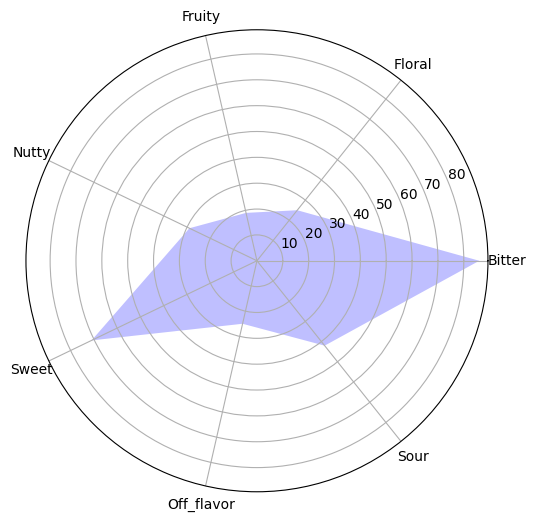

In [48]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Bitter', 'Floral', 'Fruity', 'Nutty', 'Sweet', 'Off_flavor', 'Sour']
values = [combined_data[col].sum() for col in categories]

num_categories = len(categories)
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
angles += angles[:1]

values += values[:1]

plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)
ax.fill(angles, values, 'b', alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

plt.savefig('Flavor profile.jpeg', format='jpeg', dpi=2000)

In [74]:
new_combined_data = combined_data.copy()

columns=['Bitter', 'Floral', 'Fruity', 'Off_flavor', 'Nutty', 'Sour', 'Sweet']

flavor_profiles = []

for col in columns:
    flavor_profiles.append(col)

new_combined_data['Flavor_profile'] = new_combined_data[flavor_profiles].apply(lambda x: ', '.join(x.index[x == 1]), axis=1)

new_combined_data = new_combined_data.drop(columns=flavor_profiles)

new_combined_data.to_excel('Flavor profile.xlsx', index=False)

In [83]:
new_columns_2 = {
    'Bitter': Bitter,
    'Floral': Floral,
    'Fruity': Fruity,
    'Off_flavor': Off_flavor,
    'Nutty': Nutty,
    'Sour': Sour,
    'Sweet': Sweet,

    'Bitter positive probability': Bitter_pos_proba,
    'Sour positive probability': Sour_pos_proba,
    'Fruity positive probability': Fruity_pos_proba,
    'Sweet positive probability': Sweet_pos_proba,
    'Off_flavor positive probability': Off_flavor_pos_proba,
    'Floral positive probability': Floral_pos_proba,
    'Nutty positive probability': Nutty_pos_proba,

    'Bitter negative probability': Bitter_neg_proba,
    'Sour negative probability': Sour_neg_proba,
    'Fruity negative probability': Fruity_neg_proba,
    'Sweet negative probability': Sweet_neg_proba,
    'Off_flavor negative probability': Off_flavor_neg_proba,
    'Floral negative probability': Floral_neg_proba,
    'Nutty negative probability': Nutty_neg_proba
}

probability_data = non_matches.copy()  # Create a copy to avoid modifying the original DataFrame

for column_name, values in new_columns_2.items():
    probability_data [column_name] = values

probability_data .head()

,Compound name,Fold Change,ID Level,PubChem ID,Isomeric Smiles,Processing stage,Bitter,Floral,Fruity,Off_flavor,...,Off_flavor positive probability,Floral positive probability,Nutty positive probability,Bitter negative probability,Sour negative probability,Fruity negative probability,Sweet negative probability,Off_flavor negative probability,Floral negative probability,Nutty negative probability
0,Tetrahydroxychal-\ncone 4’-O-(2’’-\nO-acetyl-6...,14.1,3,42607557,CC(=O)OC1[C@H]([C@@H](C(O[C@H]1OC2=C(C(=C(C=C2...,Fermentation,0,0,0,0,...,0.370535,0.268308,0.320639,0.771270,1.000000,0.966250,0.349446,0.629465,0.731692,0.679361
1,Tumonoic Acid H,12.2,3,25058105,CCCCCCCC[C@H](C)C(=O)N1CCC[C@H]1C(=O)O[C@H](C(...,Fermentation,0,0,0,0,...,0.235785,0.375867,0.308707,0.632766,0.571429,0.684990,0.927560,0.764215,0.624133,0.691293
4,Anhydrofructose,0.2,3,14299935,C1C(=O)C(C(C(O1)CO)O)O,Fermentation,1,0,0,0,...,0.011649,0.000895,0.085790,0.438211,1.000000,0.925228,0.382275,0.988351,0.999105,0.914210
7,Sorbosone,0.5,3,24755546,C([C@H]([C@@H]([C@H](C(=O)C=O)O)O)O)O,Fermentation,0,0,0,0,...,0.009728,0.000630,0.038224,0.995125,1.000000,1.000000,0.016793,0.990272,0.999370,0.961776
8,Maltotetraose,0.2,4,446495,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@@H]2[...,Fermentation,0,0,0,0,...,0.122890,0.020851,0.004951,0.997822,1.000000,1.000000,0.000349,0.877110,0.979149,0.995049


In [86]:
columns_to_check = ['Bitter', 'Sour', 'Fruity', 'Sweet', 'Off_flavor', 'Floral', 'Nutty']

# Create a mask for entries with value 1 in any of the flavor columns
flavor_mask = probability_data[columns_to_check].eq(1).any(axis=1)

# Create a 'profile' column containing names of columns set to 1
probability_data['Profile'] = probability_data[columns_to_check].apply(
    lambda row: ', '.join([col for col, val in zip(columns_to_check, row) if val == 1]), axis=1)

# Calculate average positive and negative probabilities for entries with value 1 in any flavor column
probability_data['Average Positive Probability'] = probability_data.loc[flavor_mask][[f"{col} positive probability" for col in columns_to_check]].mean(axis=1)
probability_data['Average Negative Probability'] = probability_data.loc[flavor_mask][[f"{col} negative probability" for col in columns_to_check]].mean(axis=1)

In [89]:
probability_data.to_excel('Probability data.xlsx', index=False)